In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.719,1.390,2.062,1.980,1.975,1.896,1.928,1.882,1.568,1.227,1.828,1.575,2.338,1.326,2.126,NaN,1.335,1.136,1.808,1.173,2.097,NaN,1.748,NaN,1.230,0.887,1.954,1.554,1.663,1.130,2.058,NaN,1.344,1.077,2.016,1.678,NaN,1.378,NaN,2.238,1.398
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.250,1.411,2.094,1.990,2.005,1.902,1.947,1.916,1.545,1.233,1.853,1.580,2.326,1.287,2.111,NaN,1.302,1.203,1.905,1.257,2.096,NaN,1.731,NaN,1.225,0.892,1.990,1.585,1.758,1.171,2.085,NaN,1.316,1.081,2.076,1.723,NaN,1.399,NaN,2.277,1.375
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.685,0.425,0.468,0.103,0.818,0.243,0.401,-0.257,0.243,1.233,1.237,1.110,0.390,1.633,-0.085,NaN,0.645,-0.110,1.016,1.521,0.093,NaN,0.667,NaN,0.481,1.145,0.696,0.963,0.973,1.262,0.080,NaN,0.440,1.584,1.169,0.821,NaN,1.323,NaN,-0.209,0.514
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.737,0.535,0.650,0.311,1.004,0.355,0.423,-0.260,0.293,1.239,1.420,1.261,0.485,1.719,-0.043,NaN,0.644,0.063,1.342,1.911,0.083,NaN,0.660,NaN,0.581,1.136,0.829,1.091,1.118,1.327,-0.002,NaN,0.463,1.607,1.408,1.054,NaN,1.488,NaN,-0.181,0.539
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.147,-0.905,-0.808,-0.649,-0.051,-0.960,-1.142,-1.254,-0.986,-0.986,-0.688,-0.744,-0.454,-0.600,-1.121,NaN,-1.136,-1.086,-0.706,-0.376,-0.965,NaN,-1.311,NaN,-1.033,-0.986,-0.944,-0.738,-0.269,-0.997,-1.182,NaN,-0.956,-1.133,-0.800,-0.735,NaN,-0.756,NaN,-1.374,-1.089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.340,2.772,2.077,2.699,2.173,2.724,2.559,1.704,2.190,2.655,1.838,2.159,1.572,2.181,NaN,1.503,3.214,3.521,2.520,2.442,NaN,1.579,NaN,2.171,2.152,3.157,2.291,3.047,1.898,2.714,NaN,1.411,2.389,3.121,2.806,NaN,2.094,NaN,2.726,1.675
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.442,-0.692,-0.653,-0.289,-0.518,-0.454,-0.900,-0.701,-0.476,-0.811,-0.623,-0.503,-0.229,-0.569,NaN,-0.662,0.435,-0.592,-0.613,-0.740,NaN,-0.422,NaN,-0.401,-0.583,-0.885,-0.778,-0.403,-0.969,-0.667,NaN,-0.700,-0.395,-0.853,-0.732,NaN,-0.705,NaN,-0.555,-0.637
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.026,-0.156,0.190,0.085,0.238,0.346,-0.599,-0.131,0.557,0.220,0.750,-0.166,1.155,-0.130,NaN,0.258,0.585,0.190,1.309,-0.005,NaN,0.694,NaN,0.312,0.870,0.181,0.972,-0.029,1.078,-0.083,NaN,0.099,1.263,0.912,1.407,NaN,1.855,NaN,0.355,0.310
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.131,-0.177,-0.151,

In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

data_split_dict['high'] = MPRA_df[cell_types].mean(axis=1) > 1


# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
high 78990
diff 38034
const 722645


In [6]:
# for data_split in ['train', 'test']:
#     pearson_df = pd.DataFrame(dtype=float)
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             condition = data_split_dict[data_split]
#             df = MPRA_df[condition]
#             x = df[f'{cell_type}'] - df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
#             y = df[f'{cell_type_2}_pred'] - df[['K562_pred', 'HepG2_pred', 'SK-N-SH_pred']].mean(axis=1)
#             r, p = pearson(x, y)
#             pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
#     print(data_split)
#     print(pearson_df)

In [7]:
# def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
#     # 排序
#     sorted_df = pd.DataFrame(
#         np.sort(df.values, axis=0),
#         index=df.index,
#         columns=df.columns
#     )
    
#     # 计算每一行的平均（也就是所有列排序后对应rank位置的平均）
#     mean_ranks = sorted_df.mean(axis=1)
    
#     # 得到每列的排序索引
#     ranks = df.rank(method="min", axis=0).astype(int) - 1  # 0-based index
    
#     # 构建归一化后的结果矩阵
#     normed = df.copy()
#     for col in df.columns:
#         normed[col] = ranks[col].apply(lambda r: mean_ranks.iloc[r])
    
#     return normed

# cell_types = ['K562', 'HepG2', 'SK-N-SH']
# df[cell_types] = quantile_normalize(df[cell_types])

In [9]:
# for data_split in ['test']:
#     pearson_df = pd.DataFrame(dtype=float)
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             df = MPRA_df[condition]
#             mean = df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
#             x = df[f'{cell_type}'] - df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1)
#             y = df[f'{cell_type_2}_pred'] - df[['K562_pred', 'HepG2_pred', 'SK-N-SH_pred']].mean(axis=1)
#             r, p = pearson(x, y)
#             pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
#     print(data_split)
#     print(pearson_df)




# plt.figure(figsize=(8, 6), dpi=100)
# plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
# sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=-0.5, vmax=0.5, 
#             annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
# plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
#         rotation=45, fontsize=14)
# plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
#         rotation=0, fontsize=14)
# plt.title(f'Pearson r of mean-subtracted pred on test set', fontsize=20)
# plt.grid(False)
# plt.savefig(f'figures/Gosai_heatmap_pred-mean_{data_split}.png', dpi=400)
# plt.show()

In [10]:

pearson_df = pd.DataFrame(dtype=float)
for cell_type in cell_types:
    for cell_type_2 in cell_types:
        condition_1 = data_split_dict['total']
        condition_2 = data_split_dict[f'{cell_type}_specific']
        df = MPRA_df[condition_1 & condition_2]
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}']
        r = pearson(x, y)[0]
        pearson_df.loc[cell_type, cell_type_2] = r
print('specific')
print(pearson_df)


# pearson_df = pd.DataFrame(dtype=float)
# for cell_type in cell_types:
#     for cell_type_2 in cell_types:
#         condition_1 = data_split_dict['test']
#         condition_2 = data_split_dict[f'{cell_type}_specific']
#         df = MPRA_df[condition_1 & condition_2]
#         x = df[f'{cell_type}']
#         y = df[f'{cell_type_2}']
#         r = pearson(x, y)[0]
#         pearson_df.loc[cell_type, cell_type_2] = r
# print('test+specific')
# print(pearson_df)



plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
            annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
        rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
        rotation=0, fontsize=14)
plt.title(f'Pearson r between cell types', fontsize=20)
plt.grid(False)
plt.savefig(f'figures/Gosai_heatmap_activity_pearson_{data_split}.png', dpi=400)
plt.show()

KeyError: 'K562_specific'

In [ ]:

# pearson_df = pd.DataFrame(dtype=float)
# for cell_type in cell_types:
#     for cell_type_2 in cell_types:
#         condition_1 = data_split_dict['total']
#         condition_2 = data_split_dict[f'{cell_type}_specific']
#         df = MPRA_df[condition_1 & condition_2]
#         x = df[f'{cell_type}']
#         y = df[f'{cell_type_2}_pred']
#         r = pearson(x, y)[0]
#         pearson_df.loc[cell_type, cell_type_2] = r
# print('specific')
# print(pearson_df)


pearson_df = pd.DataFrame(dtype=float)
for cell_type in cell_types:
    for cell_type_2 in cell_types:
        condition_1 = data_split_dict['test']
        condition_2 = data_split_dict[f'{cell_type}_specific']
        df = MPRA_df[condition_1 & condition_2]
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}_pred']
        r = pearson(x, y)[0]
        pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
print('test+specific')
print(pearson_df)



plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
            annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
        rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
        rotation=0, fontsize=14)
plt.title(f'Pearson r between cell types', fontsize=20)
plt.grid(False)
plt.savefig(f'figures/Gosai_heatmap_pred_activity_pearson_test_specific.png', dpi=400)
plt.show()

total
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.801    0.759   0.825 0.724
HepG2   0.801  1.000    0.836   0.879 0.730
SK-N-SH 0.759  0.836    1.000   0.833 0.777
HCT116  0.825  0.879    0.833   1.000 0.825
A549    0.724  0.730    0.777   0.825 1.000


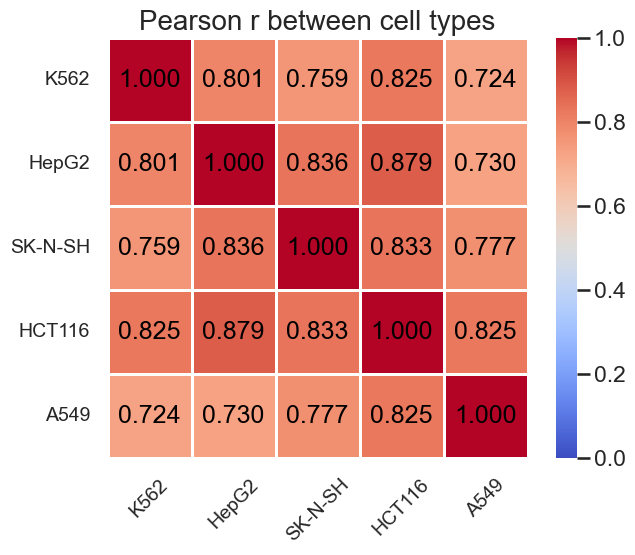

diff
         K562  HepG2  SK-N-SH  HCT116  A549
K562    1.000  0.446    0.421   0.510 0.519
HepG2   0.446  1.000    0.600   0.671 0.576
SK-N-SH 0.421  0.600    1.000   0.636 0.747
HCT116  0.510  0.671    0.636   1.000 0.758
A549    0.519  0.576    0.747   0.758 1.000


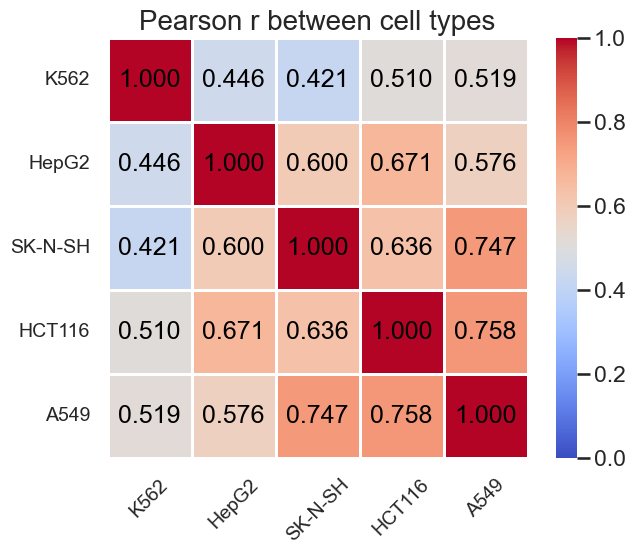

In [11]:
for data_split in ['total', 'diff']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]

            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}']
            r = pearson(x, y)[0]
            pearson_df.loc[cell_type, cell_type_2] = r
    print(data_split)
    print(pearson_df)

    # pearson_df.loc['HCT116', 'A549'] = np.nan
    # pearson_df.loc['A549', 'HCT116'] = np.nan


    plt.figure(figsize=(8, 6), dpi=100)
    # plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=1, 
                annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
            rotation=45, fontsize=14)
    plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
            rotation=0, fontsize=14)
    plt.title(f'Pearson r between cell types', fontsize=20)
    plt.grid(False)
    plt.savefig(f'figures/Gosai_heatmap_activity_pearson_{data_split}.png', dpi=400)
    plt.show()

In [12]:
for data_split in ['test', 'test_diff']:
    pearson_df = pd.DataFrame(dtype=float)
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            if data_split == 'specific' or data_split == 'high':
                condition = data_split_dict[f'{cell_type}_{data_split}']
            else:
                condition = data_split_dict[data_split]

            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r = pearson(x, y)[0]
            pearson_df.loc[cell_type, f'{cell_type_2}_pred'] = r
    print(data_split)
    print(pearson_df)

    # pearson_df.loc['HCT116', 'A549'] = np.nan
    # pearson_df.loc['A549', 'HCT116'] = np.nan


    plt.figure(figsize=(8, 6), dpi=100)
    #plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    sns.heatmap(pearson_df, square=True, linewidths=1, cmap='coolwarm', vmin=0.0, vmax=1, 
                annot=True, fmt='.3f', annot_kws={'fontsize': 18, 'color': 'black'})
    plt.xticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.columns, 
            rotation=45, fontsize=14)
    plt.yticks(ticks=np.arange(len(cell_types))+0.5, labels=pearson_df.index, 
            rotation=0, fontsize=14)
    plt.title(f'Pearson r between cell types', fontsize=20)
    plt.grid(False)
    plt.savefig(f'figures/Gosai_heatmap_pred_activity_pearson_{data_split}.png', dpi=400)
    plt.show()

KeyError: 'K562_pred'